<a href="https://colab.research.google.com/github/eyet7/Markowitz-portfolio-optimization/blob/main/notebooks/01_markowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Core libraries for data handling, visualization, and financial data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
plt.style.use("seaborn-v0_8")

In [2]:
# Assests selection
tickers = ["AAPL", "MSFT","GOOGL", "AMZN", "SPY"]

#Download historical adjusted prices
prices = yf.download(
    tickers,
    start='2019-01-01',
    end='2024-01-01',
    auto_adjust=True
)
prices.head()


[*********************100%***********************]  5 of 5 completed


Price           Close                                                    High  \
Ticker           AAPL       AMZN      GOOGL       MSFT         SPY       AAPL   
Date                                                                            
2019-01-02  37.503716  76.956497  52.338547  94.612595  224.995346  37.724579   
2019-01-03  33.768078  75.014000  50.888996  91.132004  219.626343  34.606402   
2019-01-04  35.209610  78.769501  53.499271  95.370468  226.982895  35.278483   
2019-01-07  35.131237  81.475502  53.392582  95.492119  228.772522  35.344976   
2019-01-08  35.800949  82.829002  53.861538  96.184509  230.921921  36.055060   

Price                                                    ...       Open  \
Ticker           AMZN      GOOGL       MSFT         SPY  ...       AAPL   
Date                                                     ...              
2019-01-02  77.667999  52.641756  95.202049  225.921673  ...  36.784135   
2019-01-03  76.900002  52.913203  93.742459  223.547439  ...  34.193175   
2019-01-04  79.699997  53.595048  95.913145  227.630416  ...  34.323790   
2019-01-07  81.727997  53.729037  96.624251  230.184469  ...  35.314102   
2019-01-08  83.830498  54.257544  97.279214  231.407569  ...  35.518341   

Price                                                       Volume             \
Ticker           AMZN      GOOGL       MSFT         SPY       AAPL       AMZN   
Date                                                                            
2019-01-02  73.260002  50.974850  93.143630  221.218146  148158800  159662000   
2019-01-03  76.000504  52.139549  93.658247  223.241655  365248800  139512000   
2019-01-04  76.500000  51.737085  93.302690  222.666089  234428400  183652000   
2019-01-07  80.115501  53.643187  95.099149  227.252646  219111200  159864000   
2019-01-08  83.234497  53.892800  96.409063  230.966904  164101200  177628000   

Price                                      
Ticker         GOOGL      MSFT        SPY  
Date                                       
2019-01-02  31868000  35329300  126925200  
2019-01-03  41960000  42579100  144140700  
2019-01-04  46022000  44060600  142628800  
2019-01-07  47446000  35656100  103139100  
2019-01-08  35414000  31514400  102512600  

[5 rows x 25 columns]

In [3]:
prices.shape

(1258, 25)

In [4]:
# Keep only adjusted close prices.
prices_close = prices["Close"]
prices_close.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2019-01-02,37.503716,76.956497,52.338547,94.612595,224.995346
2019-01-03,33.768078,75.014000,50.888996,91.132004,219.626343
2019-01-04,35.209610,78.769501,53.499271,95.370468,226.982895
2019-01-07,35.131237,81.475502,53.392582,95.492119,228.772522
2019-01-08,35.800949,82.829002,53.861538,96.184509,230.921921


In [5]:
# Compute daily returns
returns = prices_close.pct_change().dropna()
returns.head()

Ticker,AAPL,AMZN,GOOGL,MSFT,SPY
Date,,,,,
2019-01-03,-0.099607,-0.025241,-0.027696,-0.036788,-0.023863
2019-01-04,0.042689,0.050064,0.051294,0.046509,0.033496
2019-01-07,-0.002226,0.034353,-0.001994,0.001276,0.007884
2019-01-08,0.019063,0.016612,0.008783,0.007251,0.009395
2019-01-09,0.016982,0.001714,-0.003427,0.014299,0.004674


In [6]:
# Annualized expected returns
mu = returns.mean(axis=0) * 252

# Annalized covariance matrix
cov = returns.cov() * 252

mu, cov

(Ticker
 AAPL     0.378031
 AMZN     0.198360
 GOOGL    0.245988
 MSFT     0.320295
 SPY      0.167224
 dtype: float64,
 Ticker      AAPL      AMZN     GOOGL      MSFT       SPY
 Ticker                                                  
 AAPL    0.103907  0.070302  0.069207  0.074562  0.054450
 AMZN    0.070302  0.124055  0.073902  0.073346  0.047956
 GOOGL   0.069207  0.073902  0.101188  0.073616  0.050897
 MSFT    0.074562  0.073346  0.073616  0.092969  0.052788
 SPY     0.054450  0.047956  0.050897  0.052788  0.044082)

In [7]:
# Equal-weight portfolio

n_assets = len (mu)
w_equal = np.ones(n_assets) / n_assets
portfolio_return = np.dot(w_equal, mu)
portfolio_variance = np.dot(w_equal.T, np.dot(cov, w_equal))
portfolio_volatility = np.sqrt(portfolio_variance)

print(f"Expected annual return: {portfolio_return:.2%}")
print(f"Annual volatility: {portfolio_volatility:.2%}")


Expected annual return: 26.20%
Annual volatility: 26.44%


In [8]:
sharpe = portfolio_return / portfolio_volatility
print(f"Sharpe ratio (no risk-free rate): {sharpe:.2f}")


Sharpe ratio (no risk-free rate): 0.99


In [12]:
# Reproducibility
np.random.seed(42)

n_portfolios = 5000
n_assests = len (mu)

#Arrays to store results
port_returns = np.zeros(n_portfolios)
port_vols = np.zeros(n_portfolios)
port_sharpes = np.zeros(n_portfolios)
weights_store = np.zeros((n_portfolios, n_assests))

for i in range(n_portfolios):
  # Random long-only weights that sum to 1
  w = np.random.random(n_assets)
  w = w / w.sum()

  weights_store[i, :] = w

  # Portfolio return and risk
  r = np.dot(w, mu)
  v = np.sqrt(np.dot(w.T, np.dot(cov, w)))

  port_returns[i] = r
  port_vols[i] = v
  port_sharpes[i] = r / v


# Identify best Sharpe and minimum volatility portfolios
idx_max_sharpe = np.argmax(port_sharpes)
idx_min_vol = np.argmin(port_vols)

best_w = weights_store[idx_max_sharpe]
minvol_w = weights_store[idx_min_vol]

best_point = (port_vols[idx_max_sharpe], port_returns[idx_max_sharpe])
minvol_point = (port_vols[idx_min_vol], port_returns[idx_min_vol])

tickers = list(mu.index)

def pretty_portfolio(name, w, mu, cov):
  w = np.array(w)
  expected_return = float(np.dot(w,mu))
  volatility = float(np.sqrt(np.dot(w.T, np.dot(cov, w))))
  sharpe_ratio = expected_return / volatility

  # Create readable weight table
  weights = pd.Series(w, index=tickers).sort_values(ascending=False)

  print(f"\n{name}")
  print("-"* len(name))
  print(f"Sum of weights:         {w.sum():.6f}")
  print(f"Expected annual return: {expected_return:.2%}")
  print(f"Annual volatility:      {volatility: .2%}")
  print(f"Sharpe ratio (rf=0):    {sharpe_ratio:.2f}\n")

  print("portfolio weights:")
  display(weights.to_frame("Weight"))

# Display the two key portfolios
pretty_portfolio("Maximum Sharpe Portfolio (Random Search)", best_w, mu, cov)
pretty_portfolio("Minimum Volatility Portfolio (Random Search)",minvol_w, mu, cov )

print("\nKey points (vol, return);")
print(f"Max Sharpe point: {best_point}")
print(f"Min Vol point:    {minvol_point}")




Maximum Sharpe Portfolio (Random Search)
----------------------------------------
Sum of weights:         1.000000
Expected annual return: 33.79%
Annual volatility:       28.86%
Sharpe ratio (rf=0):    1.17

portfolio weights:


,Weight
AAPL,0.549354
MSFT,0.305281
GOOGL,0.096331
SPY,0.032881
AMZN,0.016153



Minimum Volatility Portfolio (Random Search)
--------------------------------------------
Sum of weights:         1.000000
Expected annual return: 21.28%
Annual volatility:       22.70%
Sharpe ratio (rf=0):    0.94

portfolio weights:


,Weight
SPY,0.678088
MSFT,0.146385
AAPL,0.079286
GOOGL,0.073051
AMZN,0.023189



Key points (vol, return);
Max Sharpe point: (np.float64(0.288628402951879), np.float64(0.33785156230141233))
Min Vol point:    (np.float64(0.22698031230182408), np.float64(0.2128213453633852))


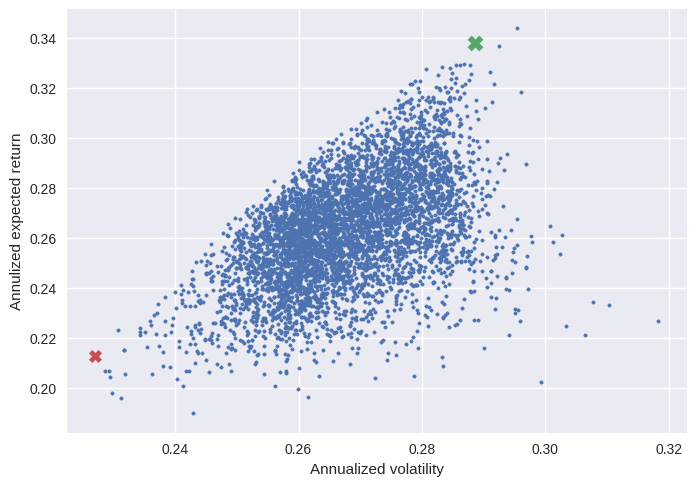

In [13]:
# Plot

plt.figure()
plt.scatter(port_vols, port_returns, s=6)
plt.xlabel("Annualized volatility")
plt.ylabel("Annulized expected return")

# Highlight max Sharpe and min vol portfolios
plt.scatter([best_point[0]], [best_point[1]], s=120, marker="X", label="Max Sharpe (random)")
plt.scatter([minvol_point[0]], [minvol_point[1]], s=80, marker="X", label = "Min vol (random)")

plt.show()

## From Random Search to Exact Optimization

In the previous section, portfolios were generated using a random search approach.
While this provides an intuitive visualization of the risk-return space, it does not guarantee that the true optimal portfolios are identified.

To obtain exact solutions, we now solve the Markowitz optimization problem using numerical optimization.

We compute:
- The Minimum Volatility Portfolio
- The Maximum Sharpe Ratio Portfolio (with a non-zero risk-free rate)

The optimization is performed under the following constraints:
- Fully invested portfolio (weights sum to 1)
- Long-only positions (no short selling)

=> This step moves from simulation-based approximation to a constrained quadratic optimization framework.




In [14]:
from scipy.optimize import minimize
tickers = list(mu.index)
n_assets = len(tickers)

def portfolio_performance(w, mu, cov):
    """Return (expected_return, volatility) with annualized inputs."""
    w = np.array(w)
    r = float(np.dot(w, mu))
    v = float(np.sqrt(np.dot(w.T, np.dot(cov, w))))
    return r, v

def portfolio_volatility(w, mu, cov):
    return portfolio_performance(w, mu, cov)[1]

def negative_sharpe(w, mu, cov, rf=0.02):
    r, v = portfolio_performance(w, mu, cov)
    return -(r - rf) / v

# Constraints: sum(w)=1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# Bounds: long-only
bounds = tuple((0.0, 1.0) for _ in range(n_assets))

# Initial guess: equal weights
w0 = np.ones(n_assets) / n_assets


In [15]:
# Minimum volatility portfolio (long-only)
res_minvol = minimize(
    portfolio_volatility, w0,
    args=(mu, cov),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_minvol_opt = res_minvol.x

# Maximum Sharpe portfolio (long-only), with risk-free rate
rf = 0.02  # 2% annual risk-free rate (assumption)
res_maxsharpe = minimize(
    negative_sharpe, w0,
    args=(mu, cov, rf),
    method="SLSQP",
    bounds=bounds,
    constraints=constraints
)

w_maxsharpe_opt = res_maxsharpe.x

res_minvol.success, res_maxsharpe.success


(True, True)

In [16]:
def display_portfolio(name, w, mu, cov, rf=0.02):
    w = np.array(w)
    r, v = portfolio_performance(w, mu, cov)
    sharpe = (r - rf) / v

    weights = pd.Series(w, index=tickers).sort_values(ascending=False)

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Sum of weights:         {w.sum():.6f}")
    print(f"Expected annual return: {r:.2%}")
    print(f"Annual volatility:      {v:.2%}")
    print(f"Sharpe ratio (rf={rf:.2%}): {sharpe:.2f}\n")
    print("Portfolio weights:")
    display(weights.to_frame("Weight"))

display_portfolio("Optimized Min Vol Portfolio (SLSQP)", w_minvol_opt, mu, cov, rf=rf)
display_portfolio("Optimized Max Sharpe Portfolio (SLSQP)", w_maxsharpe_opt, mu, cov, rf=rf)



Optimized Min Vol Portfolio (SLSQP)
-----------------------------------
Sum of weights:         1.000000
Expected annual return: 16.72%
Annual volatility:      21.00%
Sharpe ratio (rf=2.00%): 0.70

Portfolio weights:


,Weight
SPY,1.000000e+00
AMZN,9.063930e-17
AAPL,0.000000e+00
GOOGL,0.000000e+00
MSFT,0.000000e+00



Optimized Max Sharpe Portfolio (SLSQP)
--------------------------------------
Sum of weights:         1.000000
Expected annual return: 36.11%
Annual volatility:      30.13%
Sharpe ratio (rf=2.00%): 1.13

Portfolio weights:


,Weight
AAPL,7.064254e-01
MSFT,2.935746e-01
AMZN,1.227663e-16
SPY,6.295785e-19
GOOGL,0.000000e+00


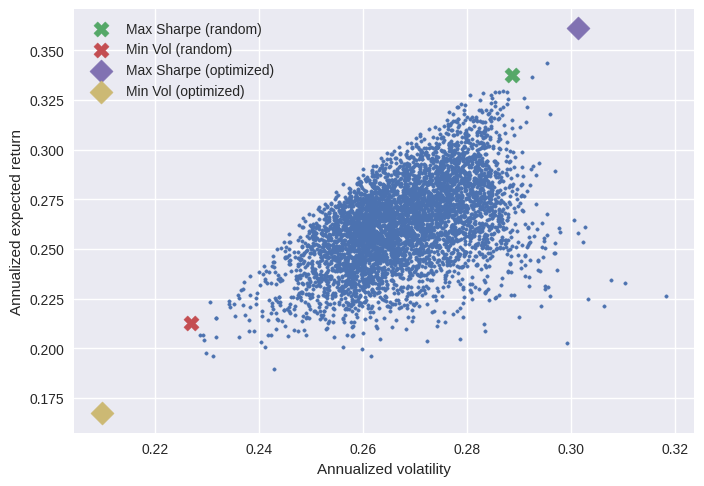

In [17]:
minvol_opt_point = portfolio_performance(w_minvol_opt, mu, cov)
maxsharpe_opt_point = portfolio_performance(w_maxsharpe_opt, mu, cov)

plt.figure()
plt.scatter(port_vols, port_returns, s=6)
plt.xlabel("Annualized volatility")
plt.ylabel("Annualized expected return")

# Random search points (your previous X markers)
plt.scatter([best_point[0]], [best_point[1]], s=120, marker="X", label="Max Sharpe (random)")
plt.scatter([minvol_point[0]], [minvol_point[1]], s=120, marker="X", label="Min Vol (random)")

# Optimized points (SLSQP)
plt.scatter([maxsharpe_opt_point[1]], [maxsharpe_opt_point[0]], s=140, marker="D", label="Max Sharpe (optimized)")
plt.scatter([minvol_opt_point[1]], [minvol_opt_point[0]], s=140, marker="D", label="Min Vol (optimized)")

plt.legend()
plt.show()
